## **Deliruim Data Cohort from MIMIC-IV-3.2 **
Data Downloaded February 8th , 2025

Phase 1 Data Extraction  
#replace this link with latest extract 
https://colab.research.google.com/drive/1IIYkR_CSGwakQJ5g47gtY1TnQIs91T02#scrollTo=71f2964d-361e-4a8a-b59f-429624b6e1ce

# Phase 2 Extracted Dataset Mounted  
Nth Attempt Feb 23, 24



In [55]:
# Define file path
file_path = "D:/MIMIC-IV-Data-Pipeline/processed_data/delirium_prediction_data_v4.csv.gz"

# Check if the file exists
import os
print("File Exists:", os.path.exists(file_path))


File Exists: True


In [57]:
import pandas as pd

file_path = "D:/MIMIC-IV-Data-Pipeline/processed_data/delirium_prediction_data_v4.csv.gz"

# Load dataset
df = pd.read_csv(file_path, compression="gzip", low_memory=False)

print("✅ Data Loaded! Shape:", df.shape)
print(df.head())  # Show first 5 rows


✅ Data Loaded! Shape: (555244, 31)
   subject_id   hadm_id  admission_type      admission_location  \
0    10000032  22595853          URGENT  TRANSFER FROM HOSPITAL   
1    10000032  22841357        EW EMER.          EMERGENCY ROOM   
2    10000032  25742920        EW EMER.          EMERGENCY ROOM   
3    10000032  29079034        EW EMER.          EMERGENCY ROOM   
4    10000068  25022803  EU OBSERVATION          EMERGENCY ROOM   

  discharge_location insurance marital_status   race  ed_time_spent  los_hosp  \
0               HOME  Medicaid        WIDOWED  WHITE          253.0  0.786111   
1               HOME  Medicaid        WIDOWED  WHITE          337.0  1.015278   
2            HOSPICE  Medicaid        WIDOWED  WHITE          286.0  1.754167   
3               HOME  Medicaid        WIDOWED  WHITE          486.0  2.222222   
4                NaN       NaN         SINGLE  WHITE          511.0  0.298611   

   ... prior_icu_admissions    crp  creatinine  glucose sodium  wbc_count  

Updated Data Cleaning & Outlier Removal Strategy after EDA rounds
A. Handle Non-physiological Time Values
Rather than dropping rows with negative values (which may lose valuable information), we convert these erroneous values to NaN. This allows for later imputation or analysis of missingness patterns.

B. Apply Clinical Thresholds to ICU Lab & Vital Signs
We use clinically informed thresholds to flag values for key ICU variables. These thresholds are consistent with prior work using MIMIC data (e.g., Johnson et al., 2016; Harutyunyan et al., 2019). Out-of-range values will be set to missing.

C. Flag Missing Measurements
For lab and vital sign variables, indicator variables are created to flag missing data, which might itself be informative in a clinical prediction context.

In [59]:
import pandas as pd
import numpy as np
 
data = df
# --- Step 1: Handle Non-physiological Time Values ---
# Instead of removing rows, set negative ED time spent and hospital LOS values to NaN
data.loc[data['ed_time_spent'] < 0, 'ed_time_spent'] = np.nan
data.loc[data['los_hosp'] < 0, 'los_hosp'] = np.nan

# --- Step 2: Clean ICU Lab & Vital Signs Based on Clinical Thresholds ---
def clean_variable(df, col, lower_bound, upper_bound):
    """
    Replace values outside the [lower_bound, upper_bound] range with NaN.
    """
    condition = (df[col] >= lower_bound) & (df[col] <= upper_bound)
    df.loc[~condition, col] = np.nan
    return df

# Heart Rate: plausible range 30 - 220 bpm
data = clean_variable(data, 'heart_rate', 30, 220)

# Systolic Blood Pressure: plausible range 50 - 250 mmHg
data = clean_variable(data, 'systolic_bp', 50, 250)

# Respiratory Rate: plausible range 5 - 60 breaths per minute
data = clean_variable(data, 'respiratory_rate', 5, 60)

# Temperature: plausible range 30 - 42 °C (verify units)
data = clean_variable(data, 'temperature', 30, 42)

# Glucose: plausible range 40 - 500 mg/dL
data = clean_variable(data, 'glucose', 40, 500)

# Creatinine: plausible range 0.1 - 15 mg/dL
data = clean_variable(data, 'creatinine', 0.1, 15)

# CRP: plausible range 0.5 - 500 mg/L (example range, adjust if needed)
data = clean_variable(data, 'crp', 0.5, 500)

# --- Step 3: Create Missingness Flags for Lab Measurements ---
lab_columns = ['glucose', 'sodium', 'wbc_count', 'heart_rate', 'systolic_bp', 'respiratory_rate', 'temperature', 'crp', 'creatinine']
for col in lab_columns:
    flag_name = f'{col}_missing'
    data[flag_name] = data[col].isnull().astype(int)

# --- Optional: Further Cleaning for ICU-Specific Variables ---
# For instance, create an ICU flag based on the availability of 'stay_id'
data['icu_flag'] = data['stay_id'].notnull().astype(int)

# --- Save the Cleaned Data ---
#data.to_csv("D:/MIMIC-IV-Data-Pipeline/processed_data/delirium_prediction_data_v4_cleaned.csv.gz", index=False, compression='gzip')
df= data

In [61]:
# Drop the `delirium_x` column if it exists
df = df.drop(columns=["delirium_x"], errors="ignore")

In [63]:
print("🔍 Dataset Overview:")
print(df.info())  # Check column types and memory usage
print("\nMissing Values:\n", df.isnull().sum())  # Count missing values


🔍 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555244 entries, 0 to 555243
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   subject_id                555244 non-null  int64  
 1   hadm_id                   555244 non-null  int64  
 2   admission_type            555244 non-null  object 
 3   admission_location        555243 non-null  object 
 4   discharge_location        405420 non-null  object 
 5   insurance                 545797 non-null  object 
 6   marital_status            540815 non-null  object 
 7   race                      555244 non-null  object 
 8   ed_time_spent             385222 non-null  float64
 9   los_hosp                  555067 non-null  float64
 10  gender                    555244 non-null  object 
 11  anchor_age                555244 non-null  int64  
 12  anchor_year               555244 non-null  int64  
 13  stay_id                 

In [65]:
# prompt: rename los to icu _os

df = df.rename(columns={'los': 'icu_los'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555244 entries, 0 to 555243
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   subject_id                555244 non-null  int64  
 1   hadm_id                   555244 non-null  int64  
 2   admission_type            555244 non-null  object 
 3   admission_location        555243 non-null  object 
 4   discharge_location        405420 non-null  object 
 5   insurance                 545797 non-null  object 
 6   marital_status            540815 non-null  object 
 7   race                      555244 non-null  object 
 8   ed_time_spent             385222 non-null  float64
 9   los_hosp                  555067 non-null  float64
 10  gender                    555244 non-null  object 
 11  anchor_age                555244 non-null  int64  
 12  anchor_year               555244 non-null  int64  
 13  stay_id                   94458 non-null   f

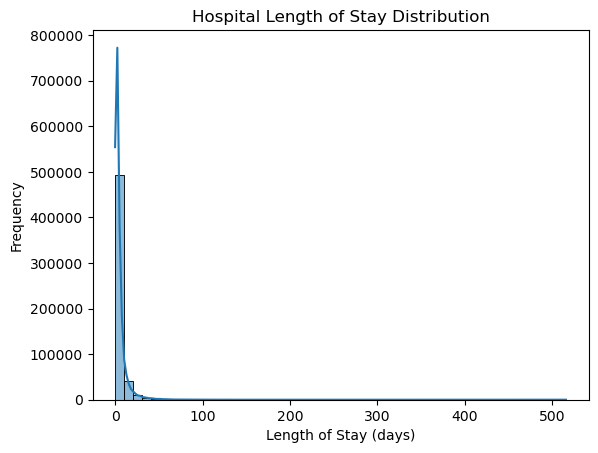

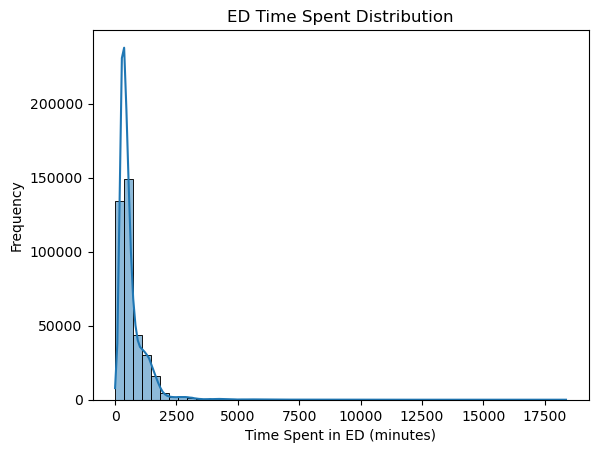

admission_type
EW EMER.                       182097
EU OBSERVATION                 119458
OBSERVATION ADMIT               85902
URGENT                          56820
SURGICAL SAME DAY ADMISSION     43501
DIRECT OBSERVATION              24551
DIRECT EMER.                    22369
ELECTIVE                        13351
AMBULATORY OBSERVATION           7195
Name: count, dtype: int64


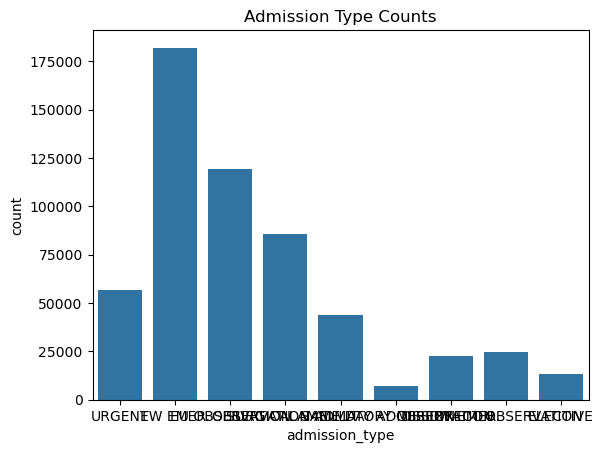

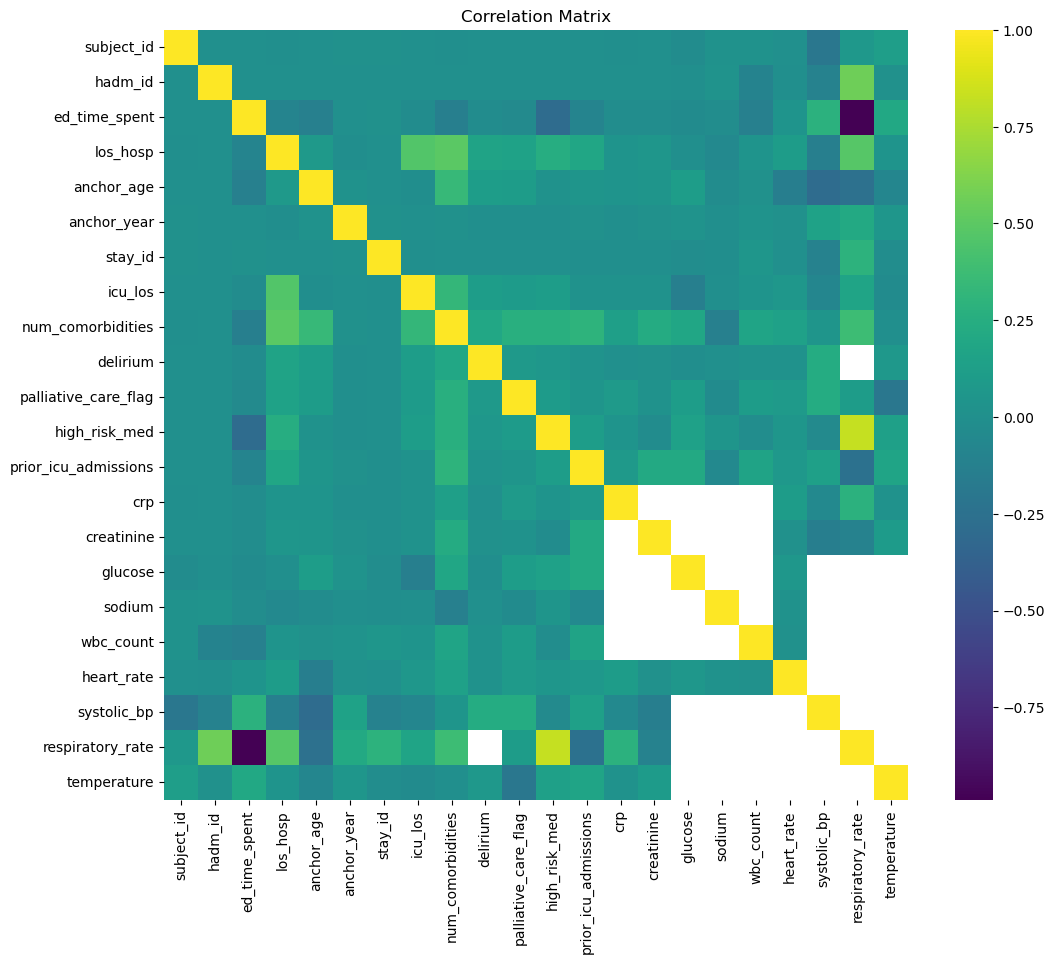

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
#data = pd.read_csv("D:/MIMIC-IV-Data-Pipeline/processed_data/delirium_prediction_data_v4.csv.gz", compression='gzip')
data = df

# Quick look at the data structure
print(data.info())
print(data.head())

# Summary statistics for continuous variables
print(data.describe())

# Check missing values
missing_values = data.isnull().sum().sort_values(ascending=False)
print("Missing values by column:\n", missing_values)

# Visualize distribution of key variables (e.g., los_hosp, ed_time_spent)
sns.histplot(data['los_hosp'], bins=50, kde=True)
plt.title('Hospital Length of Stay Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

sns.histplot(data['ed_time_spent'].dropna(), bins=50, kde=True)
plt.title('ED Time Spent Distribution')
plt.xlabel('Time Spent in ED (minutes)')
plt.ylabel('Frequency')
plt.show()

# Frequency counts for categorical variables
print(data['admission_type'].value_counts())
sns.countplot(x='admission_type', data=data)
plt.title('Admission Type Counts')
plt.show()

# Correlation matrix for continuous variables
corr_matrix = data.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()


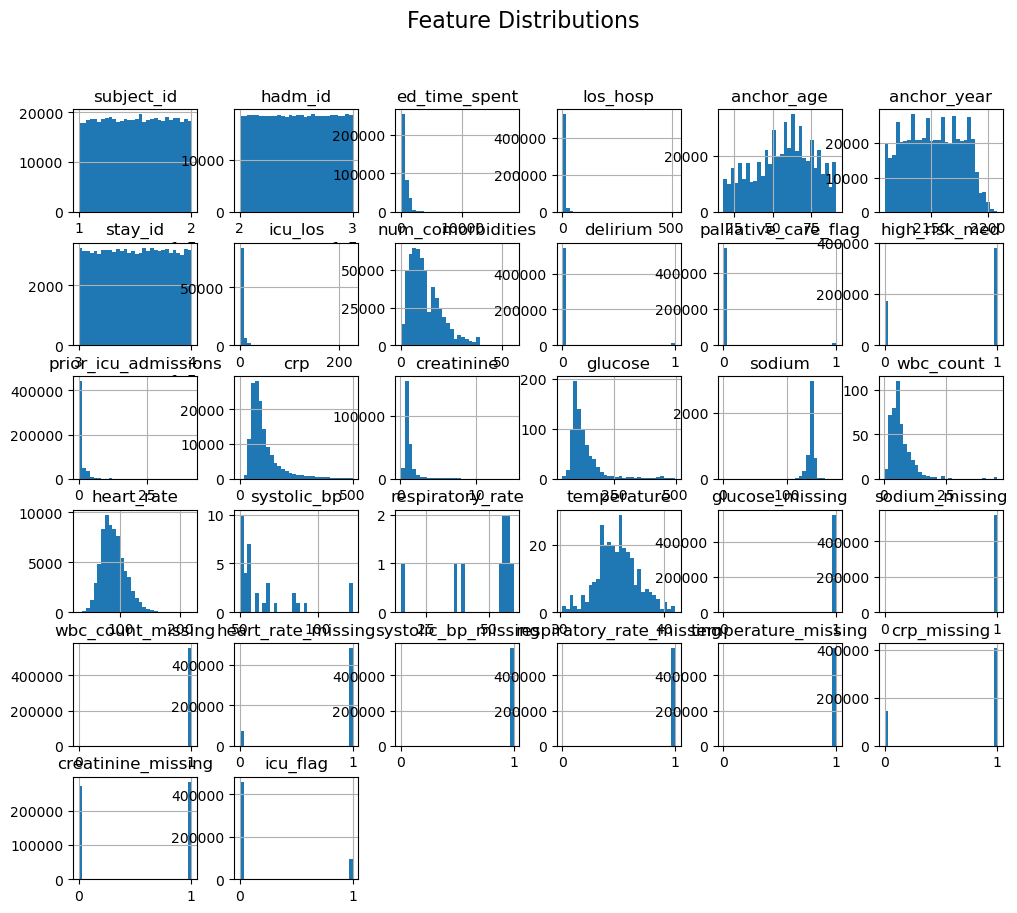

In [68]:
import matplotlib.pyplot as plt

# Plot histograms for numerical columns
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


✅ Next Steps: Handling Missing Data



Delirium Rate by Admission Type:
 admission_type
AMBULATORY OBSERVATION         0.000557
DIRECT EMER.                   0.015529
DIRECT OBSERVATION             0.000898
ELECTIVE                       0.018140
EU OBSERVATION                 0.000905
EW EMER.                       0.028100
OBSERVATION ADMIT              0.031829
SURGICAL SAME DAY ADMISSION    0.015988
URGENT                         0.024508
Name: delirium, dtype: float64
Delirium Rate by ICU Status:
 icu_flag
0    0.011230
1    0.058083
Name: delirium, dtype: float64


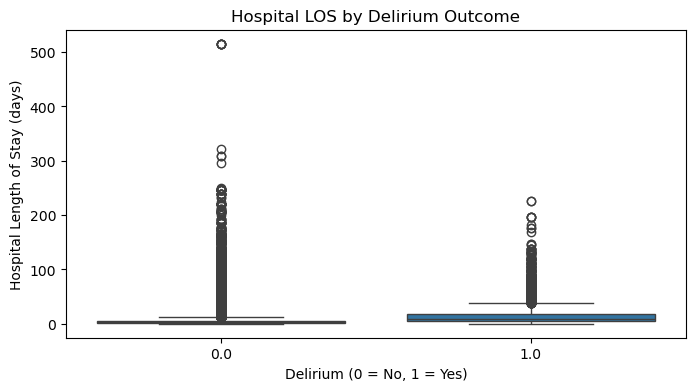

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Load   final cleaned dataset
#data = pd.read_csv("D:/MIMIC-IV-Data-Pipeline/processed_data/delirium_prediction_data_v4_final_cleaned.csv.gz", compression='gzip')
data = df
# ---- Outcome Exploration ----
# Check delirium prevalence across admission types and ICU status
delirium_by_admtype = data.groupby('admission_type')['delirium'].mean()
print("Delirium Rate by Admission Type:\n", delirium_by_admtype)

delirium_by_icu = data.groupby('icu_flag')['delirium'].mean()
print("Delirium Rate by ICU Status:\n", delirium_by_icu)

# Visualize distribution of a continuous predictor by outcome
plt.figure(figsize=(8,4))
sns.boxplot(x='delirium', y='los_hosp', data=data)
plt.title("Hospital LOS by Delirium Outcome")
plt.xlabel("Delirium (0 = No, 1 = Yes)")
plt.ylabel("Hospital Length of Stay (days)")
plt.show()


In [73]:
#1️⃣ Fill or Remove Missing diagnosis_list Entries

# Since diagnoses drive delirium and palliative_care_flag, replace missing lists with an empty list:

df["diagnosis_list"] = df["diagnosis_list"].apply(lambda x: x if isinstance(x, list) else [])


In [75]:

# 2️⃣ Fill palliative_care_flag and delirium with 0
#If a patient has no diagnosis data, assume 0 for both:
df["palliative_care_flag"] = df["palliative_care_flag"].fillna(0).astype(int)


In [77]:
df["delirium"] = df["delirium"].fillna(0).astype(int)

# 3️⃣ Fill high_risk_med with 0
# Missing values likely mean no high-risk medications were prescribed.

df["high_risk_med"] = df["high_risk_med"].fillna(0).astype(int)


In [83]:
# ---- Feature Engineering ----
# Create a composite comorbidity flag (example: binary indicator if num_comorbidities > threshold)
data['high_comorbidity'] = (data['num_comorbidities'] > data['num_comorbidities'].median()).astype(int)

# Log-transform hospital LOS to address skewness (if appropriate)
data['log_los_hosp'] = np.log1p(data['los_hosp'])

In [85]:
#4️⃣ Handle Missing ICU Data (stay_id, last_careunit, los)
#Since not all patients were in the ICU, replace missing values with "Not ICU" or 0:
df["stay_id"] = df["stay_id"].fillna("Not ICU")
df["last_careunit"] = df["last_careunit"].fillna("Not ICU")
# This didnt work #df["los_icu"] = df["los_icu"].fillna(0)


In [87]:
# 5️⃣ Handle Missing ed_time_spent
#Patients missing ed_time_spent likely didn’t enter via the ED.
#Fill missing values with 0:
df["ed_time_spent"] = df["ed_time_spent"].fillna(0)

In [99]:
output_path = "D:/MIMIC-IV-Data-Pipeline/processed_data"
os.makedirs(output_path, exist_ok=True)  # Ensure the directory exists

# Save as a compressed CSV file
file_name = "delirium_prediction_data_v4.1_cleaned.csv.gz"
df.to_csv(os.path.join(output_path, file_name), index=False, compression="gzip")


In [89]:
# ---- Missing Data Indicator is already created for lab values ----

# ---- Data Partitioning: Example using StratifiedKFold ----
# Ensure splitting is done on a patient level if necessary (here we assume unique subjects)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(data, data['delirium']):
    train, test = data.iloc[train_index], data.iloc[test_index]
    print("Train delirium rate:", train['delirium'].mean(), "Test delirium rate:", test['delirium'].mean())

Train delirium rate: 0.019187518995035964 Test delirium rate: 0.0191897270574251
Train delirium rate: 0.019187518995035964 Test delirium rate: 0.0191897270574251
Train delirium rate: 0.019187518995035964 Test delirium rate: 0.0191897270574251
Train delirium rate: 0.019187518995035964 Test delirium rate: 0.0191897270574251
Train delirium rate: 0.0191897270574251 Test delirium rate: 0.01918089474821699


In [95]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc

# Define your feature set and target
features = ['ed_time_spent', 'los_hosp', 'anchor_age', 'num_comorbidities', 
            'high_risk_med', 'icu_flag', 'log_los_hosp', 'high_comorbidity']
target = 'delirium'

X = df[features]
y = df[target]

# Create a pipeline that first imputes missing values, then scales the data, then fits LogisticRegression
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # impute NaNs with the median of each feature
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Define hyperparameter grid for tuning
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']  # liblinear supports l1 penalty
}

# Stratified KFold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X, y)
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate overall performance
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X)[:, 1]
auc_score = roc_auc_score(y, y_pred_prob)
print("Overall ROC AUC:", auc_score)

# Precision-Recall AUC
precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

# Detailed classification report using a threshold of 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y, y_pred))



Best hyperparameters: {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Overall ROC AUC: 0.8856535479096046
Precision-Recall AUC: 0.13883727587376213
              precision    recall  f1-score   support

           0       1.00      0.78      0.88    544590
           1       0.07      0.84      0.13     10654

    accuracy                           0.78    555244
   macro avg       0.53      0.81      0.50    555244
weighted avg       0.98      0.78      0.86    555244



In [97]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc
import pandas as pd
import numpy as np

# Load your cleaned dataset 

# Define features and target
features = ['ed_time_spent', 'los_hosp', 'anchor_age', 'num_comorbidities', 
            'high_risk_med', 'icu_flag', 'log_los_hosp', 'high_comorbidity']
target = 'delirium'

X = df[features]
y = df[target]

# Identify feature groups
continuous_features = ['ed_time_spent', 'los_hosp', 'anchor_age', 'num_comorbidities', 'log_los_hosp']
binary_features = ['high_risk_med', 'icu_flag', 'high_comorbidity']

# Create pipelines for each group
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    # Binary features may not require scaling.
])

# Create a column transformer to apply different imputations
preprocessor = ColumnTransformer(transformers=[
    ('cont', continuous_pipeline, continuous_features),
    ('bin', binary_pipeline, binary_features)
])

# Create full pipeline with preprocessor and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Define hyperparameter grid for logistic regression
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']  # liblinear supports l1 penalty
}

# Set up stratified KFold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X, y)
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate overall performance
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X)[:, 1]
auc_score = roc_auc_score(y, y_pred_prob)
print("Overall ROC AUC:", auc_score)

# Precision-Recall AUC evaluation
precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

# Classification report (using a threshold of 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y, y_pred))


Best hyperparameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Overall ROC AUC: 0.8856762615591969
Precision-Recall AUC: 0.1388492011429312
              precision    recall  f1-score   support

           0       1.00      0.78      0.88    544590
           1       0.07      0.84      0.13     10654

    accuracy                           0.78    555244
   macro avg       0.53      0.81      0.50    555244
weighted avg       0.98      0.78      0.86    555244



In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
import xgboost as xgb   # ran !pip install xgboost first

# Load the cleaned dataset
 

# Define features and target
features = ['ed_time_spent', 'los_hosp', 'anchor_age', 'num_comorbidities', 
            'high_risk_med', 'icu_flag', 'log_los_hosp', 'high_comorbidity']
target = 'delirium'

X = df[features]
y = df[target]

# Define feature groups for custom imputation:
continuous_features = ['ed_time_spent', 'los_hosp', 'anchor_age', 'num_comorbidities', 'log_los_hosp']
binary_features = ['high_risk_med', 'icu_flag', 'high_comorbidity']

# Pipelines for each group
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

preprocessor = ColumnTransformer(transformers=[
    ('cont', continuous_pipeline, continuous_features),
    ('bin', binary_pipeline, binary_features)
])

# Build a pipeline with XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Hyperparameter grid for XGBoost
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__scale_pos_weight': [round((len(y)-y.sum())/y.sum())]  # to account for imbalance
}

# Set up stratified KFold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=skf, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X, y)
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate overall performance
best_model = grid_search.best_estimator_
y_pred_prob = best_model.predict_proba(X)[:, 1]
auc_score = roc_auc_score(y, y_pred_prob)
print("Overall ROC AUC:", auc_score)

# Evaluate Precision-Recall AUC
precision, recall, thresholds = precision_recall_curve(y, y_pred_prob)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

# Classification report using a default threshold of 0.5
y_pred = (y_pred_prob >= 0.5).astype(int)
print(classification_report(y, y_pred))


In [91]:
print("🔍 Dataset Overview:")
print(df.info())  # Check column types and memory usage
print("\nMissing Values:\n", df.isnull().sum())  # Count missing values

🔍 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555244 entries, 0 to 555243
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   subject_id                555244 non-null  int64  
 1   hadm_id                   555244 non-null  int64  
 2   admission_type            555244 non-null  object 
 3   admission_location        555243 non-null  object 
 4   discharge_location        405420 non-null  object 
 5   insurance                 545797 non-null  object 
 6   marital_status            540815 non-null  object 
 7   race                      555244 non-null  object 
 8   ed_time_spent             555244 non-null  float64
 9   los_hosp                  555067 non-null  float64
 10  gender                    555244 non-null  object 
 11  anchor_age                555244 non-null  int64  
 12  anchor_year               555244 non-null  int64  
 13  stay_id                 

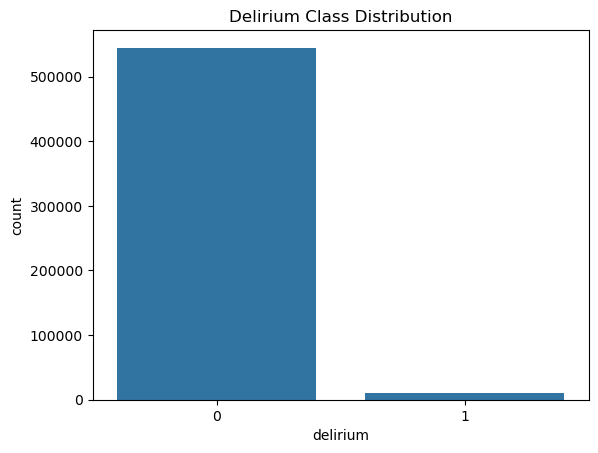

delirium
0    0.980812
1    0.019188
Name: proportion, dtype: float64


In [25]:
# EDA Part 2

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="delirium", data=df)
plt.title("Delirium Class Distribution")
plt.show()
print(df["delirium"].value_counts(normalize=True))  # Class balance check


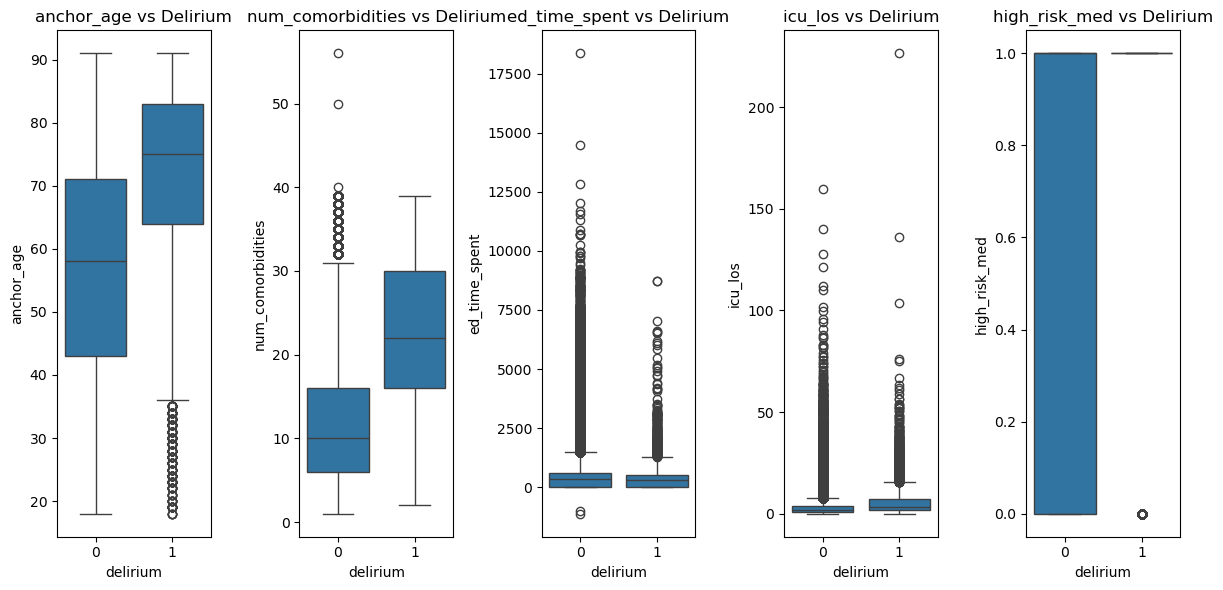

In [29]:
# Explore Key Features by Delirium Status
features = ["anchor_age", "num_comorbidities", "ed_time_spent", "icu_los","high_risk_med"]
plt.figure(figsize=(12, 6))

for i, feature in enumerate(features, 1):
    plt.subplot(1, len(features), i)
    sns.boxplot(x="delirium", y=feature, data=df)
    plt.title(f"{feature} vs Delirium")

plt.tight_layout()
plt.show()

In [31]:
#Step 1 : Feature Engineering
#1️⃣ Encode Categorical Variables
categorical_cols = ["admission_type", "admission_location", "discharge_location", "insurance", "race", "gender", "marital_status"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
#Why? One-hot encoding allows models to use categorical variables in numerical format.
#2️⃣ Handle Missing Values in Numerical Columns
df["icu_los"] = df["icu_los"].fillna(0)  # Fill missing ICU LOS with 0 (non-ICU admissions)
df["num_comorbidities"] = df["num_comorbidities"].fillna(0)
#Why? Keeps numerical data clean for modeling.

#3️⃣ Drop Unnecessary Identifiers
df = df.drop(columns=["subject_id", "hadm_id", "stay_id", "anchor_year"])
#Why? These IDs don't contribute to prediction.  Not considering repeated patient admissions as each admission should be treated seprately?

In [33]:
# Identify categorical columns that may still contain text
categorical_cols = ["last_careunit"]

# Convert categorical columns to numerical encoding
df[categorical_cols] = df[categorical_cols].astype("category").apply(lambda x: x.cat.codes)

print("✅ Categorical variables converted to numeric!")


✅ Categorical variables converted to numeric!


In [35]:
# Drop non-numeric columns before applying SMOTE

df = df.drop(columns=["diagnosis_list"])

print("✅ Removed non-numeric columns before SMOTE.")


✅ Removed non-numeric columns before SMOTE.


In [37]:
#🔹 Step 2: Train-Test Split with SMOTE
#1️⃣ Define Features (X) and Target (y)

# Define target variable
y = df["delirium"]

# Drop target column from features
X = df.drop(columns=["delirium"])
#2️⃣ Split Data into Training & Testing Sets

from sklearn.model_selection import train_test_split

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train-test split completed!")
print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")
# Why? Stratifying ensures the same delirium proportion in both train and test sets.


✅ Train-test split completed!
Training Set: (444195, 77), Test Set: (111049, 77)


In [41]:
#3️⃣ Apply SMOTE to Handle Class Imbalance

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

In [43]:
# Apply SMOTE only on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("✅ SMOTE applied! New class distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))
#Why? Ensures balanced training data while keeping test data unchanged for fair evaluation.

✅ SMOTE applied! New class distribution:
delirium
0    0.5
1    0.5
Name: proportion, dtype: float64


1️⃣ Feature Scaling (Standardization or Normalization)
Machine learning models, especially Logistic Regression, SVM, and Neural Networks, benefit from feature scaling.

Option 1: Standardization (Recommended for Most Models)
Scales numerical features to have mean = 0 and standard deviation = 1.

In [45]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns to scale
numeric_cols = ["anchor_age", "num_comorbidities", "ed_time_spent", "icu_los"]

# Apply standardization
scaler = StandardScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("✅ Features standardized!")


✅ Features standardized!


In [47]:
print("✅ Final Data Check:")
print(f"Training Set Shape: {X_train_resampled.shape}, {y_train_resampled.shape}")
print(f"Test Set Shape: {X_test.shape}, {y_test.shape}")


✅ Final Data Check:
Training Set Shape: (871344, 77), (871344,)
Test Set Shape: (111049, 77), (111049,)


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
print("✅ Model Performance:")
print(classification_report(y_test, y_pred))


✅ Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    108918
           1       0.16      0.16      0.16      2131

    accuracy                           0.97    111049
   macro avg       0.57      0.57      0.57    111049
weighted avg       0.97      0.97      0.97    111049



In [51]:
log_model = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)


LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

🔹 Next Steps to Improve Performance
1️⃣ Increase max_iter to allow convergence

python
Copy
Edit
log_model = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)
log_model.fit(X_train_resampled, y_train_resampled)
2️⃣ Ensure Feature Scaling



In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
print("✅ Model Performance:")
print(classification_report(y_test, y_pred))


✅ Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    108918
           1       0.16      0.16      0.16      2131

    accuracy                           0.97    111049
   macro avg       0.57      0.57      0.57    111049
weighted avg       0.97      0.97      0.97    111049

